In [45]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
import gc
from IPython.display import clear_output
from collections import defaultdict

from functools import lru_cache

def sum_2_tuples(a, b):
    return tuple(map(sum, zip(a, b)))

Experiment parameters:

In [30]:
TRADES_DIR = '../TRADES/USD_TOM_trades_Micex_02_10.feather'
LOB_DIR = '../Data_lob/'

RANDOM_MOMENTS_FILE = '../0_CommonFiles/random_moments_aligned_to_1000_2000.pkl'
SIGNATURE_FILE = './signature.db3'

TRADE_SIZE_MIN_INCLUSIVE = 1000
TRADE_SIZE_MAX_EXCLUSIVE = 1100

In [28]:
# Signature hedger
volume = 1_000 # in contracts

look_back_time = np.timedelta64(30, 's')

hedge_params_df = pd.DataFrame({
    'zone_number': [1, 2, 3],
    'distance': [1, 5, 10],
    'proportion': [0.3, 0.2, 0.1]
})

In [33]:
with open(RANDOM_MOMENTS_FILE, 'rb') as file:
    moments = pickle.load(file)

In [34]:
len(moments)

2712

# 1. Select big trades

In [4]:
trades = pd.read_feather(TRADES_DIR)

In [5]:
trade_temp = trades.groupby(['Time', 'AGGRESSOR_SIDE'], as_index=False).sum()

In [6]:
volume_weighted_trade_price = trade_temp['TRADE_VALUE'] / trade_temp['SIZE'] / 1000.0

In [7]:
trade_temp['PRICE'] = volume_weighted_trade_price
# round to 0.01 of cent
trades['PRICE'] = trades['PRICE'].round(4)

In [8]:
trades = trade_temp

In [9]:
del trade_temp

In [10]:
#look only on big trades
trades = trades[(trades.SIZE >= TRADE_SIZE_MIN_INCLUSIVE) & (trades.SIZE < TRADE_SIZE_MAX_EXCLUSIVE)]

# 2. Build signature

In [14]:
signature_table = {
    'B': {
        (100, 499):   [0.0024905292322913285, 0.0026433182635482626, 0.002697568954515778, 0.002754871518810317, 0.0027752543082661374, 0.0028078903944222097, 0.0028371652741295862, 0.002847808719280013, 0.0028629920749483452, 0.0028644201398436335, 0.002902226078334742, 0.0029074442675728735, 0.002909906263110637, 0.002920145213701039, 0.0029235891185313977, 0.0029301488175850834, 0.0029372444769760727, 0.0029551045002256904, 0.002967188583503694, 0.0029792892963725706, 0.003030206853470199, 0.0030455028641086295, 0.0030361961146199213, 0.003037642986828899, 0.003047899841558298, 0.0030454963201911197, 0.0030526111305911024, 0.003057226325988928, 0.0030565060371562664, 0.00304376181684737],
        (500, 999):   [0.0026910899881976646, 0.002876574048739949, 0.002954233358535151, 0.003004949016366884, 0.003051637010818458, 0.003155480831982127, 0.0032022998510619623, 0.0032067194415670575, 0.0032198526432204995, 0.0032461271190022552, 0.003316403526027055, 0.003348364191854261, 0.003382860725006834, 0.0033982864133026806, 0.003416631622502073, 0.0034439206651035196, 0.0034502304663365426, 0.0034699038516893947, 0.0034927645055142713, 0.0035066473844458652, 0.003557687851464374, 0.0035595092792224665, 0.0035653776916127, 0.0035530782397924818, 0.0035613312440704622, 0.0035661420643975034, 0.0035718473977402877, 0.0035835479654684537, 0.00360718410967474, 0.0036128712728256715],
        (1000, 1999): [0.004612341943448629, 0.00470303210971194, 0.004739355350991369, 0.004756822374477201, 0.004770824837943304, 0.004812400062769874, 0.0048387798928851145, 0.004828780297409278, 0.0048642111992043355, 0.0048948626351468065, 0.004910218723984043, 0.004887823304729127, 0.004932528527765032, 0.004911338680908534, 0.004911278319943477, 0.004880698744659351, 0.004923283029468591, 0.004910424956089112, 0.004932294400206548, 0.004955211724933123, 0.004963611473046904, 0.005004210988770786, 0.005002578327983672, 0.005010618520081839, 0.0050076751191620965, 0.005044662839871767, 0.005075435694415131, 0.005073996103970367, 0.00508851019301986, 0.005083605829427722],
        (2000, 2999): [0.007666860013730193, 0.007643789023029769, 0.007652402066997683, 0.007613438051744633, 0.007614776792131339, 0.007502060470679352, 0.0075052798384596265, 0.007552209078378696, 0.007517176678966911, 0.007531715385564781, 0.007483064873911523, 0.007428261624852005, 0.007469441111481189, 0.007374616830424646, 0.0073684494057514455, 0.007305188287727694, 0.007232535700494532, 0.007274966262455883, 0.007390991475109071, 0.007427080430026108, 0.007431972843167495, 0.007426670597037147, 0.0073594906840288256, 0.00732305074441914, 0.007278815445096429, 0.007283750842030177, 0.007318336045351533, 0.007320043061559275, 0.007378172975640467, 0.007426300513799741],
        (3000, 3999): [0.009674008146040854, 0.009594498750866546, 0.009523753635455986, 0.009415641260702419, 0.009247837921464483, 0.00933503498220464, 0.009277199524990488, 0.009292350809572029, 0.009209022491318938, 0.009075989417298902, 0.009069096460127404, 0.008942232763600304, 0.009036936492981215, 0.009030853634262365, 0.009053667229322226, 0.009102777991050979, 0.009074072798063661, 0.00918350715436552, 0.0091641956874766, 0.00915439691789643, 0.00905721982629974, 0.009179315898859751, 0.009239740959752309, 0.009123399560758687, 0.009069593964616589, 0.008900625072984975, 0.008930201349958393, 0.008894070702762092, 0.009053905993548605, 0.008901185965190536],
        (4000, 4999): [0.011019889178636652, 0.011441198417186441, 0.011105431809768135, 0.011148529862105707, 0.011417548194302468, 0.011361981369996148, 0.01132618883567955, 0.011368819335707462, 0.011563397010111769, 0.011873061573159035, 0.0117197120970133, 0.01185161970097324, 0.011850805141290345, 0.01188601861527688, 0.0117790126443318, 0.011510710136511828, 0.011644152465413704, 0.011700125096293482, 0.011649358483612466, 0.011687462865742921, 0.011916583861082805, 0.011878289032676563, 0.01207941101879102, 0.012175605618630151, 0.012251549957490634, 0.01243124102886145, 0.012545704816970833, 0.012537714755208915, 0.012456087269594924, 0.012601588499248887],
        (5000, 5999): [0.009752595144464879, 0.009710915814622032, 0.009442979565791883, 0.009568342484458967, 0.009600821152447949, 0.00990578351907795, 0.009932260287593569, 0.009837965853948472, 0.00966540179856852, 0.009673962782141984, 0.009626877350233123, 0.009891261370888119, 0.010099024930627006, 0.01040851357086885, 0.010349333254191075, 0.010325257097068661, 0.01007730186831571, 0.01013435307997328, 0.010072955006161233, 0.010112540519686386, 0.010590693249442219, 0.01102417343108075, 0.011126782049952606, 0.01094982892843211, 0.010941644412129534, 0.011057090625790612, 0.011330102764629818, 0.011472762239011168, 0.011149269176548692, 0.01131296380607968],
        # ??? copy results for 5000-5999
        (6000, 1000000): [0.009752595144464879, 0.009710915814622032, 0.009442979565791883, 0.009568342484458967, 0.009600821152447949, 0.00990578351907795, 0.009932260287593569, 0.009837965853948472, 0.00966540179856852, 0.009673962782141984, 0.009626877350233123, 0.009891261370888119, 0.010099024930627006, 0.01040851357086885, 0.010349333254191075, 0.010325257097068661, 0.01007730186831571, 0.01013435307997328, 0.010072955006161233, 0.010112540519686386, 0.010590693249442219, 0.01102417343108075, 0.011126782049952606, 0.01094982892843211, 0.010941644412129534, 0.011057090625790612, 0.011330102764629818, 0.011472762239011168, 0.011149269176548692, 0.01131296380607968]
    },
    'S': {
        (100, 499):   [-0.002691961920942539, -0.0028218211718799174, -0.0028526589224838624, -0.0028580376926901057, -0.0028554915302185426, -0.0028715145253223814, -0.002892245132825392, -0.002917789041322858, -0.0029401823740718186, -0.0029468314074382472, -0.002966728525845394, -0.002982267277371796, -0.0029956516900289634, -0.0030053244866775257, -0.003014695901351538, -0.0030689010638763146, -0.0030739605354541673, -0.0030778089280789575, -0.003067598021875995, -0.0030704625041084, -0.003097924784737163, -0.0031019103469523404, -0.0031078246667001807, -0.0031344306091877928, -0.0031704390863474194, -0.0031862293510007984, -0.0031799665756465662, -0.0031765049864934634, -0.0031675934803442165, -0.0031961782294462975],
        (500, 999):   [-0.003008004466562672, -0.0031912751646871232, -0.0032467112890713526, -0.0032607366979502087, -0.0032648957081756556, -0.0032709954302336188, -0.00327360221832405, -0.0032897902474548677, -0.003308227730510537, -0.0033210146283061018, -0.003387044834705139, -0.003378095054457927, -0.0033538402745523542, -0.003355872942904236, -0.0033635644305300394, -0.003405175290050012, -0.003403924048792436, -0.0034102931548327, -0.0034047582602718396, -0.0033956189805064733, -0.0034858723031213268, -0.003465391695813379, -0.0034771176678052847, -0.00347568541315807, -0.0034998747813142833, -0.003529806317990441, -0.003506756427493522, -0.0034893681334655694, -0.0034902468507876276, -0.003508570475398435],
        (1000, 1999): [-0.005193527548200116, -0.0053838014627723444, -0.005402806578284014, -0.00543410081791218, -0.005412053312792029, -0.005472204404052999, -0.0054955736618325065, -0.005525343264595411, -0.005548110821957607, -0.005569054210315334, -0.005567431960921996, -0.005554403572277654, -0.005574627243539157, -0.0055716513554180305, -0.005573081132148346, -0.00558488020683325, -0.005629225883774346, -0.00566259193964533, -0.005622225625124084, -0.005608585487945004, -0.005625586022881097, -0.00564591369330999, -0.0056556044406593465, -0.0056854235969587, -0.005713757978951893, -0.005767603214608918, -0.005737164047361523, -0.005750507698046928, -0.005750483826174665, -0.005789134591693843],
        (2000, 2999): [-0.008772532023005432, -0.008736440237200447, -0.00864071731179626, -0.008544224583353096, -0.008405019827083185, -0.00842515509726803, -0.008430296925373905, -0.008388579154313961, -0.008475364452445133, -0.008514497085523693, -0.008438669567902289, -0.00845897993666488, -0.008502637468935552, -0.008537800517944014, -0.008599350476616795, -0.008595145849275823, -0.008548945261920009, -0.008548854374433073, -0.00856299259324292, -0.008578076602230776, -0.00860636546575176, -0.008546389272189526, -0.008434613305679736, -0.008461867077007376, -0.008513358115444467, -0.00851437134906376, -0.008506239865189079, -0.008559544883079565, -0.008537952615015552, -0.008550979625147002],
        (3000, 3999): [-0.011650249871759721, -0.011652507980316522, -0.011428646460492638, -0.011296664818182872, -0.011108769959144116, -0.010753379840007862, -0.010904103664097662, -0.010850310322040264, -0.010937717759928717, -0.011050993124673659, -0.010912228212921427, -0.011021726452862606, -0.011204422983069303, -0.011344730432164172, -0.011289843640146834, -0.011298736762360055, -0.011488414631182322, -0.01138611127223616, -0.0113674158517282, -0.011492847772814367, -0.011416581505829937, -0.011391728273509281, -0.011444262948521505, -0.01137037579692953, -0.011301540836656656, -0.011478391220936683, -0.01160197606041419, -0.011795934700036221, -0.011818350553284658, -0.011633203311841384],
        (4000, 4999): [-0.01114950631995241, -0.011162250593862581, -0.011277315685737942, -0.011209797128188783, -0.011291138714941919, -0.01130973134553277, -0.011351357282652547, -0.01177774409391618, -0.011679075618075754, -0.011799609730924856, -0.011860618116177024, -0.011917534319117894, -0.011961431612554935, -0.011983307015411214, -0.011982966390406156, -0.012080630394631866, -0.01200226885101033, -0.011999803941175459, -0.011898603325597674, -0.012018945611891872, -0.012245730524373012, -0.012279839944683716, -0.012227665359045589, -0.012035700438750357, -0.011993569730108572, -0.01203636668121768, -0.012261569331689435, -0.012357793037477716, -0.012332823490384233, -0.012573643228148244],
        (5000, 5999): [-0.010886281841212774, -0.010909766916686381, -0.01084644532848205, -0.010833785438672647, -0.01090003835236758, -0.010924942169616725, -0.010740406167922462, -0.010668919209943352, -0.01079079193381028, -0.010737813976872946, -0.010938418645686548, -0.010975720465114053, -0.010862777731241006, -0.010468382338453026, -0.01049630362309003, -0.010400533002998109, -0.010530070150458842, -0.01048533193953031, -0.010392612827167066, -0.010397852353878892, -0.010575881143408163, -0.01078093641122272, -0.010823641380151126, -0.011011893532463452, -0.011201870383060286, -0.011250730937168022, -0.011125539631192187, -0.01093584323456253, -0.010944043691882706, -0.011085875722578327],
#         # ??? copy results for 5000-5999
         (6000, 1000000): [-0.010886281841212774, -0.010909766916686381, -0.01084644532848205, -0.010833785438672647, -0.01090003835236758, -0.010924942169616725, -0.010740406167922462, -0.010668919209943352, -0.01079079193381028, -0.010737813976872946, -0.010938418645686548, -0.010975720465114053, -0.010862777731241006, -0.010468382338453026, -0.01049630362309003, -0.010400533002998109, -0.010530070150458842, -0.01048533193953031, -0.010392612827167066, -0.010397852353878892, -0.010575881143408163, -0.01078093641122272, -0.010823641380151126, -0.011011893532463452, -0.011201870383060286, -0.011250730937168022, -0.011125539631192187, -0.01093584323456253, -0.010944043691882706, -0.011085875722578327]
    }
}


'''
Convert signature table
into signature table with diffs 
delta(t) = signature(t+1) - signature(t)
'''
def build_delta_signature(signature_table):
    output = {}
    for side in signature_table:
        if side not in output:
            output[side] = {}
        
        for size, array in signature_table[side].items():
            # for 1..N we store only delta - change from previous moment
            delta_signature = np.array(array[1:]) - np.array(array[:-1])
            
            '''
            for initial time T0 we store array[0],
            price jump before deal and after deal
            '''
            delta_signature = np.insert(delta_signature, obj=0, values=array[0]) 
            
            output[side][size] = delta_signature
            
    return output

delta_signature_table = build_delta_signature(signature_table)

In [16]:
'''
aggregate multiple signatures
into one
'''
def build_multitrades_signature(trades_before):
    signature = defaultdict(float)

    for trade in trades_before.itertuples():
        side = trade.AGGRESSOR_SIDE
        for size_range in signature_table[side]:
            if size_range[0] <= trade.SIZE <= size_range[1]:
                break

        delta_signature = delta_signature_table[side][size_range]

        times = {trade.Time + np.timedelta64(sec, 's') : delta_signature[sec] 
               for sec in range(30)}

        for k, v in times.items():
            signature[k] += v
        
    signature = (sorted(signature.items()))

    reconstructed_signature = []
    total = 0

    for (k,v) in signature:
        total += v
        reconstructed_signature.append((k, total))

    return reconstructed_signature

# 3. Hedge functions

In [17]:
def get_trades_before(moment):
    global look_back_time, trades
    moment_before = moment - look_back_time
    index1 = trades.Time.searchsorted(moment_before, side='left')
    index2 = trades.Time.searchsorted(moment, side='right')
    trades_before = trades.iloc[index1 : index2]
    return trades_before

In [21]:
'''
@returns 
zone1time - time, when zone1 ends and zone2 starts
zone2time - time, when zone2 ends and zone3 starts
'''
def get_zone_times(moment, side, skip_empty_trades = False):
    #1 get trades before our trade
    trades_before = get_trades_before(moment)
    
    if len(trades_before) == 0:
        if skip_empty_trades == False:
            #Columns: [Time, AGGRESSOR_SIDE, PRICE, SIZE, TRADE_VALUE]
            trades_before.loc[-1] = [moment, side, -1.0, 1000, -1000.0]  # adding a row
            trades_before.index = trades_before.index + 1  # shifting index
            trades_before = trades_before.sort_index()  # sorting by index
        else:
            return None, None

    #2 mix them into signature
    reference_signature = build_multitrades_signature(trades_before)
    #3 find three zones
    mmax = max(reference_signature, key = lambda item: item[1])
    mmin = min(reference_signature, key = lambda item: item[1])
    
    if side == 'B':
        zone1price = mmin[1] + (mmax[1] - mmin[1]) * 0.33
        zone2price = mmin[1] + (mmax[1] - mmin[1]) * 0.66
    
        for (k, v) in reference_signature:
            if v >= zone1price:
                #print(k)
                zone1time = k
                break
            
        for (k, v) in reference_signature:
            if v >= zone2price:
                #print(k)
                zone2time = k
                break
    else:
        zone1price = mmax[1] - (mmax[1] - mmin[1]) * 0.33
        zone2price = mmax[1] - (mmax[1] - mmin[1]) * 0.66
        
        for (k, v) in reference_signature:
            if v <= zone1price:
                #print(k)
                zone1time = k
                break
            
        for (k, v) in reference_signature:
            if v <= zone2price:
                #print(k)
                zone2time = k
                break
                
    #4 return result
    return zone1time, zone2time

In [22]:
def make_hedge(lob, datetime, size, side):
    #lob = lob[lob['Time'] >= datetime]
    time_index = lob['Time'].searchsorted(datetime, side='right')
        
    if time_index >= len(lob):
        return (0, 0.0)
    row = lob.iloc[time_index] # first timestamp >= datetime
    
    quote_side = 'BID' if (side == 'S') else 'ASK'
    
    maxsize = sum([row[quote_side + '_SIZE' + str(level)] for level in range(1, 11)])
        
    if maxsize < size:
        raise ValueError(f'size {size} is greater than available {maxsize}')
    
    size_hedged, sum_hedged = 0, 0.0
    level = 1
    while size_hedged < size and level < 11:
        portion = min(size - size_hedged, row[quote_side + '_SIZE' + str(level)])
        price = row[quote_side + '_PRICE' + str(level)]
        size_hedged += portion
        sum_hedged += portion * price
        print(f'added {portion} by {price}')
        level += 1
        
    print('HEDGE ended')
    return (size_hedged, sum_hedged)

In [25]:
class LOBCache:
    def __init__(self):
        pass
    
    def get_lob(self, datetime):
        #print(datetime)
        filename = datetime.strftime('LOB_%m%d.feather')
        return self.__get_lob_by_filename(filename)
        pass
    
    @lru_cache(maxsize=4)
    def __get_lob_by_filename(self, filename):
        print(filename)
        lob = pd.read_feather(LOB_DIR + filename).dropna()
        lob['BID_SIZE1'] = 99_999_999
        lob['ASK_SIZE1'] = 99_999_999
        return lob

In [26]:
cache = LOBCache()

In [27]:
def calc_hedge_signature(cache, moment, hedge_params_df):
    curr_moment = moment
    print(hedge_params_df)

    lob = cache.get_lob(curr_moment)
    remain = volume
    total = None
    
    zone1time, zone2time = get_zone_times(curr_moment, side, skip_empty_trades = True)
    print('zone1time, zone2time','\n',zone1time,'\n', zone2time)
    if zone1time is None:
        remain = 0
        total = (-2, -2.0)
    while remain > 0:
        print(curr_moment)
        
        # select our zone
        if moment <= curr_moment <= zone1time:
            print('we are in 1st zone')
            zone = 1
        elif zone1time < curr_moment <= zone2time:
            print('we are in 2nd zone')
            zone = 2
        else:
            print('we are in 3rd zone')
            zone = 3
        
        row = hedge_params_df[hedge_params_df['zone_number'] == zone]
        size_contracts = int(volume * row['proportion'])
        size_contracts = min(size_contracts, remain)

        hedge_result = make_hedge(lob, curr_moment, size = size_contracts, side = side)

        interval =  row['distance'].iloc[0]
        curr_moment = curr_moment + np.timedelta64(interval, 's')
        if hedge_result is None:
            break
        
        if hedge_result[0] == 0:
            return (-1, -1.0)
        
        if total is None:
            total = hedge_result
        else:
            total = sum_2_tuples(total, hedge_result)
            
        print(hedge_result)
        remain -= hedge_result[0]
        if remain == 0:
            break
            
    del lob
            
    if remain > 0:
        return None
    else:
        return total

# 4. Calculation

In [37]:
#CREATE TABLE RESULT(MOMENT TEXT, SIDE TEXT, QUANTITY INTEGER, SUM REAL, PRIMARY KEY(MOMENT,SIDE));
sign_sql = sqlite3.connect(SIGNATURE_FILE)
sign_sql.execute('CREATE TABLE IF NOT EXISTS RESULT(MOMENT TEXT, SIDE TEXT, QUANTITY INTEGER, SUM REAL, PRIMARY KEY(MOMENT,SIDE));')
cur=sign_sql.cursor()

In [47]:
records = []

for moment in moments:
    for side in ('B', 'S'):
        record = (str(moment),side)
        query='select exists(select 1 from result where moment=? and side=? collate nocase) limit 1'
        # 'query' RETURNS 1 IF USERNAME EXISTS OR 0 IF NOT, AS INTEGER(MAYBE). 'collate nocase'= CASE INSENSITIVE, IT'S OPTIONAL
        check=cur.execute(query,record) 
        if check.fetchone()[0]==1:
            print(f'Moment already available ' + str(record))
            continue

        print('calculating for moment', moment)
        result = calc_hedge_signature(cache, moment, hedge_params_df)

        query='INSERT OR REPLACE INTO result(moment, side, quantity, sum) VALUES(?, ?, ?, ?);'
        if result:
            record = (str(moment), side, int(result[0]), result[1])
        else:
            record = (str(moment), side, -1, -1)

        print(record)
        cur.execute(query, record)
        records.append(record)

        gc.collect()

        if len(records) % 100 == 0:
            clear_output(wait=False)

calculating for moment 2021-10-06 13:23:34.159810
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-10-06 13:23:38.159810 
 2021-10-06 13:23:46.159810
2021-10-06 13:23:34.159810
we are in 1st zone
added 300 by 72.725
HEDGE ended
(300, 21817.5)
2021-10-06 13:23:35.159810
we are in 1st zone
added 300 by 72.725
HEDGE ended
(300, 21817.5)
2021-10-06 13:23:36.159810
we are in 1st zone
added 300 by 72.725
HEDGE ended
(300, 21817.5)
2021-10-06 13:23:37.159810
we are in 1st zone
added 100 by 72.725
HEDGE ended
(100, 7272.499999999999)
('2021-10-06 13:23:34.159810', 'B', 1000, 72725.0)
calculating for moment 2021-10-06 13:23:34.159810
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-10-06 13:23:34.159810 
 2021-10-06 13:23:34.159810
2021-10-06 13

calculating for moment 2021-10-06 15:11:23.178082
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 None 
 None
('2021-10-06 15:11:23.178082', 'B', -2, -2.0)
calculating for moment 2021-10-06 15:11:23.178082
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 None 
 None
('2021-10-06 15:11:23.178082', 'S', -2, -2.0)
calculating for moment 2021-10-06 15:22:44.063087
   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
zone1time, zone2time 
 2021-10-06 15:22:19.436189 
 2021-10-06 15:22:19.436189
2021-10-06 15:22:44.063087
we are in 3rd zone
added 100 by 72.4975
HEDGE ended
(100, 7249.75)
2021-10-06 15:22:54.063087
we are in 3rd zone
added 100 by 72.4775
HEDG

In [48]:
sign_sql.commit()

In [49]:
cur.close()
sign_sql.close()

# Temporary

Checking *searchsorted* function:

In [82]:
ser = pd.Series([1,2,2,2,3,3,4])

In [91]:
i1 = ser.searchsorted(4-2, side='left')
i2 = ser.searchsorted(4, side='right')
i1, i2

(1, 7)

In [92]:
ser.iloc[i1:i2]

1    2
2    2
3    2
4    3
5    3
6    4
dtype: int64

Checking calculations for '2021-03-04 22:34:56.123456'

In [49]:
moment = pd._libs.tslibs.timestamps.Timestamp('2021-03-04 22:34:56.123456')

moment.strftime('LOB_%m%d.feather')

res = cache.get_lob(moment)

#result = make_hedge(res, moment, size = 10000, side='B')
result = calc_hedge_signature(cache, moment, hedge_params_df)
print(result)

   zone_number  distance  proportion
0            1         1         0.3
1            2         5         0.2
2            3        10         0.1
skip_empty_trades True
zone1time, zone2time 
 2021-03-04 22:34:27.776566 
 2021-03-04 22:34:27.776566
2021-03-04 22:34:56.123456
we are in 3rd zone
added 70 by 74.28
added 184 by 74.275
added 250 by 74.2725
added 100 by 74.27
added 50 by 74.2675
added 140 by 74.265
added 140 by 74.2625
added 50 by 74.26
added 16 by 74.2525
HEDGE ended
(1000, 74269.58999999998)
2021-03-04 22:35:06.123456
we are in 3rd zone
added 100 by 74.2525
added 200 by 74.25
added 100 by 74.2475
added 100 by 74.245
added 200 by 74.24
added 50 by 74.2375
added 100 by 74.235
added 80 by 74.225
added 70 by 74.2225
HEDGE ended
(1000, 74241.45)
2021-03-04 22:35:16.123456
we are in 3rd zone
added 49 by 74.265
added 179 by 74.2625
added 290 by 74.26
added 150 by 74.255
added 100 by 74.2525
added 100 by 74.25
added 50 by 74.2475
added 82 by 74.2425
HEDGE ended
(1000, 74256.13249

In [75]:
tb = get_trades_before(moment)

In [76]:
#tb = tb.iloc[0:1, :]
tb

,Time,AGGRESSOR_SIDE,PRICE,SIZE,TRADE_VALUE
912773,2021-03-04 22:34:27.776566,B,74.28000,1175,87279000.0
912788,2021-03-04 22:34:28.940570,B,74.29827,1000,74298270.0
912789,2021-03-04 22:34:28.950866,B,74.30000,1000,74300000.0
912791,2021-03-04 22:34:29.258022,B,74.30000,1000,74300000.0


(start zone №2 - Timestamp('2021-03-04 22:34:28.950866'),

 start zone №3 - Timestamp('2021-03-04 22:34:29.258022'))

In [ ]:
moment = pd._libs.tslibs.timestamps.Timestamp('2021-03-04 22:34:56.123456')

In [79]:
ms = build_multitrades_signature(tb)

signature with deltas
[(Timestamp('2021-03-04 22:34:27.776566'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:28.776566'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:28.940570'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:28.950866'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:29.258022'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:29.776566'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:29.940570'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:29.950866'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:30.258022'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:30.776566'), 1.7467023485831512e-05), (Timestamp('2021-03-04 22:34:30.940570'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:30.950866'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:31.258022'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:31.776566'), 1.4002463466103107e-05), (Timestamp('2021-03-04 22:34:31.940570'), 1.74670234858

In [80]:
ms

[(Timestamp('2021-03-04 22:34:27.776566'), 0.004612341943448629),
 (Timestamp('2021-03-04 22:34:28.776566'), 0.00470303210971194),
 (Timestamp('2021-03-04 22:34:28.940570'), 0.00931537405316057),
 (Timestamp('2021-03-04 22:34:28.950866'), 0.013927715996609198),
 (Timestamp('2021-03-04 22:34:29.258022'), 0.01854005794005783),
 (Timestamp('2021-03-04 22:34:29.776566'), 0.018576381181337257),
 (Timestamp('2021-03-04 22:34:29.940570'), 0.018667071347600567),
 (Timestamp('2021-03-04 22:34:29.950866'), 0.01875776151386388),
 (Timestamp('2021-03-04 22:34:30.258022'), 0.018848451680127193),
 (Timestamp('2021-03-04 22:34:30.776566'), 0.018865918703613024),
 (Timestamp('2021-03-04 22:34:30.940570'), 0.018902241944892453),
 (Timestamp('2021-03-04 22:34:30.950866'), 0.01893856518617188),
 (Timestamp('2021-03-04 22:34:31.258022'), 0.01897488842745131),
 (Timestamp('2021-03-04 22:34:31.776566'), 0.01898889089091741),
 (Timestamp('2021-03-04 22:34:31.940570'), 0.019006357914403242),
 (Timestamp('2021

In [81]:
get_zone_times(moment, side='B', skip_empty_trades=True)

skip_empty_trades True
signature with deltas
[(Timestamp('2021-03-04 22:34:27.776566'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:28.776566'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:28.940570'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:28.950866'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:29.258022'), 0.004612341943448629), (Timestamp('2021-03-04 22:34:29.776566'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:29.940570'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:29.950866'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:30.258022'), 9.069016626331132e-05), (Timestamp('2021-03-04 22:34:30.776566'), 1.7467023485831512e-05), (Timestamp('2021-03-04 22:34:30.940570'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:30.950866'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:31.258022'), 3.632324127942916e-05), (Timestamp('2021-03-04 22:34:31.776566'), 1.4002463466103107e-05), (Timestamp('2021-03-04 22:34:31.

(Timestamp('2021-03-04 22:34:28.950866'),
 Timestamp('2021-03-04 22:34:29.258022'))

<AxesSubplot:xlabel='Time'>

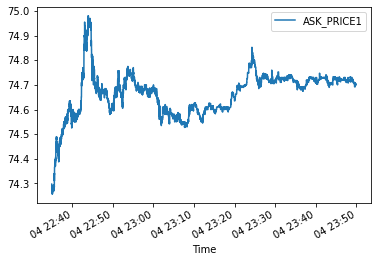

In [91]:
res[res.Time >= moment][['Time', 'ASK_PRICE1']].plot(x='Time', y='ASK_PRICE1')

In [65]:
cache.get_lob(pd._libs.tslibs.timestamps.Timestamp('2021-10-08 18:34:56.123456')).to_csv('20211008.csv', sep=';')

In [161]:
c = cache.get_lob(moment)

2021-02-05 13:12:34.123456


In [171]:
c

,Time,BID_PRICE1,BID_SIZE1,ASK_PRICE1,ASK_SIZE1,BID_PRICE2,BID_SIZE2,ASK_PRICE2,ASK_SIZE2,BID_PRICE3,...,ASK_PRICE8,ASK_SIZE8,BID_PRICE9,BID_SIZE9,ASK_PRICE9,ASK_SIZE9,BID_PRICE10,BID_SIZE10,ASK_PRICE10,ASK_SIZE10
0,2021-02-05 03:00:00.000000,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1,2021-02-05 10:00:00.028238,NaN,0,75.5375,200,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
2,2021-02-05 10:00:00.028529,NaN,0,75.5375,200,NaN,0,75.5400,200,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
3,2021-02-05 10:00:00.028898,NaN,0,75.5375,200,NaN,0,75.5400,200,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
4,2021-02-05 10:00:00.029049,NaN,0,75.5375,200,NaN,0,75.5400,200,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540862,2021-02-05 23:49:59.586873,74.6425,58,74.6600,99,74.64,298,74.6625,50,74.6375,...,74.680,177,74.62,41,74.685,3,74.6175,21,74.690,8
1540863,2021-02-05 23:49:59.586873,74.6425,58,74.6450,95,74.64,298,74.6600,99,74.6375,...,74.675,46,74.62,41,74.680,177,74.6175,21,74.685,3
1540864,2021-02-05 23:49:59.587401,74.6425,58,74.6450,73,74.64,298,74.6600,99,74.6375,...,74.675,46,74.62,41,74.680,177,74.6175,21,74.685,3
1540865,2021-02-05 23:49:59.587617,74.6425,58,74.6450,73,74.64,298,74.6600,99,74.6375,...,74.680,177,74.62,41,74.685,3,74.6175,21,74.690,8


In [172]:
d

,Time,BID_PRICE1,BID_SIZE1,ASK_PRICE1,ASK_SIZE1,BID_PRICE2,BID_SIZE2,ASK_PRICE2,ASK_SIZE2,BID_PRICE3,...,BID_PRICE9,BID_SIZE9,ASK_PRICE9,ASK_SIZE9,BID_PRICE10,BID_SIZE10,ASK_PRICE10,ASK_SIZE10,BID1M,BIDVOL1M
39,2021-02-05 10:00:00.220981,75.4300,1000,75.500,100,75.3175,100,75.5025,200,75.1025,...,73.245,1400,75.5375,200,73.2425,2,75.540,200,75.4300,1000
40,2021-02-05 10:00:00.231000,75.4300,1000,75.500,100,75.3175,100,75.5025,200,75.1025,...,73.845,1,75.5375,200,73.2450,1400,75.540,200,75.4300,1000
41,2021-02-05 10:00:00.238228,75.4300,1000,75.500,100,75.3175,100,75.5025,200,75.1025,...,73.845,1,75.5375,200,73.2450,1400,75.540,200,75.4300,1000
42,2021-02-05 10:00:00.238228,75.4300,1000,75.500,100,75.3175,100,75.5025,267,75.1025,...,73.845,1,75.5375,200,73.2450,1400,75.540,200,75.4300,1000
43,2021-02-05 10:00:00.258073,75.4300,1000,75.500,100,75.3175,100,75.5025,267,75.1025,...,73.845,1,75.5375,200,73.2450,1400,75.540,200,75.4300,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540862,2021-02-05 23:49:59.586873,74.6425,58,74.660,99,74.6400,298,74.6625,50,74.6375,...,74.620,41,74.6850,3,74.6175,21,74.690,8,74.6425,58
1540863,2021-02-05 23:49:59.586873,74.6425,58,74.645,95,74.6400,298,74.6600,99,74.6375,...,74.620,41,74.6800,177,74.6175,21,74.685,3,74.6425,58
1540864,2021-02-05 23:49:59.587401,74.6425,58,74.645,73,74.6400,298,74.6600,99,74.6375,...,74.620,41,74.6800,177,74.6175,21,74.685,3,74.6425,58
1540865,2021-02-05 23:49:59.587617,74.6425,58,74.645,73,74.6400,298,74.6600,99,74.6375,...,74.620,41,74.6850,3,74.6175,21,74.690,8,74.6425,58


In [188]:
%%timeit
d['Time'].searchsorted(moment, side='right')

110 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [190]:
%%timeit
d['Time'] >= moment

3.59 ms ± 84.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
